# SIkR and SEkIkR Models

In order to model the delayed nature of both incubation and recovery, we can add additional compartments representing disease progression. In the SIkR model we add addiional stages to the infectious state, say $I_i^{\alpha}$ which transition to each other in equal rates

$$
\dot{I}^{\alpha}_i (t) = \gamma_I k \left(I_i^{{\alpha}-1} - I_{i}^{\alpha}\right)
$$

with a total of $\alpha=1,2,\dots k$ stages. In the SEkIkR model, we also add additional exposed stages which model the virus incubation period

$$
\dot{E}^{\alpha}_i (t) = \gamma_E k \left(E_i^{{\alpha}-1} - E_{i}^{\alpha}\right)
$$

with a total of $k$ stages.

The multiplication of the intrisic rates by $k$ preserves the mean transition time regardless of the number of stages, $\langle T \rangle = \gamma^{-1}$. However, increasing the number of stages reduces the uncertainty of the transition time, such that $\sigma_T = \gamma^{-1}/\sqrt{k}$.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)
from scipy import optimize

## SIkR Model
We now initial an SIkR model with one infected individual, assuming an average incubation and recovery time of three weeks $\pm$10%.

In [3]:
beta = 0.
gIs   = 1.0 / 21           # Assume combined incubation and recovery time of three weeks

M = 4; Ni = np.ones(M) * 1e3;
N = np.sum(Ni);

IdM = np.eye(M);
def contactMatrix(t) : 
    return IdM;

K = 100;                  # so stddev of recovery time is 10% of mean
I0 = np.zeros((K,M));
I0[0,:]= 1;
S0 = np.zeros(M)  
for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i])
I0 = np.reshape(I0, K*M);
Tf=35; Nf = 10*Tf+1

parameters = {'beta':beta, 'gI':gIs, 'k':K}
model = pyross.deterministic.SIkR(parameters, M, Ni)
data=model.simulate(S0, I0, contactMatrix, Tf, Nf)

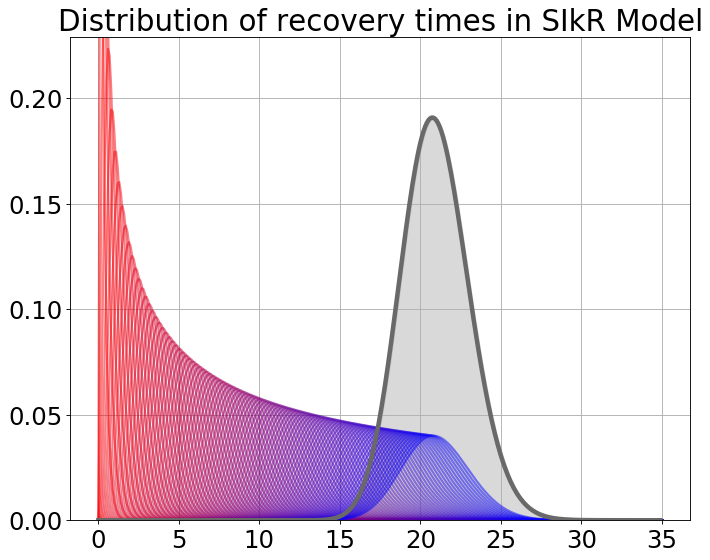

In [4]:
S = data['X'][:, 0];
Is1 = np.transpose(data['X'][:, (M)::M])
t = data['t'];

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

for i in range(K) :
    plt.plot(t, Is1[i], lw = 2, color = np.array([1 - i/K,0,i/K]), alpha = 0.5)
    

plt.plot(t[0:-1], np.diff(1 - (np.sum(Is1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey')
plt.fill_between(t[0:-1], np.diff(1 - (np.sum(Is1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey', alpha = 0.25)
plt.grid()
plt.ylim(0, 1.2 * np.max(np.diff(1 - (np.sum(Is1,0))/np.diff(t)[0] ) ))
plt.title("Distribution of recovery times in SIkR Model");

## SEkIkR Model
We now refine the model by using two separate stages for the incubation and recovery. We now take an incubation period of two weeks $\pm$25%, and a recovery time of one week $\pm$10%, and initialize the model with a single exposed, incubating case. We find that the mean time to recovery from the moment of exposure is still three weeks. However, the variance is now larger because of the elavated uncertainty in the incubation period

In [5]:
beta = 0.
gIs   = 1.0 / 7           # Recovery rate of a week
gE = 1.0 / 14;            # Incubation period of two weeks
 

M = 4; Ni = np.ones(M) * 1e3;
N = np.sum(Ni);

IdM = np.eye(M);
def contactMatrix(t) : 
    return IdM;

K = 100; # So stddiv in recovery time is 10% of mean
KE = 16; # So stddiv in recovery time is 25% of mean
S0 = np.zeros(M)  
I0 = np.zeros((K,M));
E0 = np.zeros((KE,M));

# I0[0,:]= 1;
E0[0,:]= 1;

for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i]) - np.sum(E0[:,i])
I0 = np.reshape(I0, K*M);
E0 = np.reshape(E0, KE*M);

Tf=35; Nf = 10*Tf+1

parameters = {'beta':beta, 'gE':gE, 'gI':gIs, 'kI':K, 'kE' : KE}
model = pyross.deterministic.SEkIkR(parameters, M, Ni)
data=model.simulate(S0, E0, I0, contactMatrix, Tf, Nf)

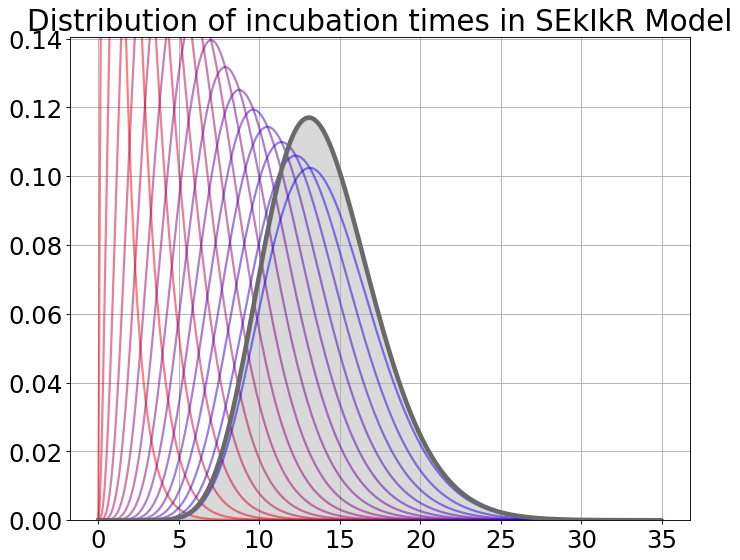

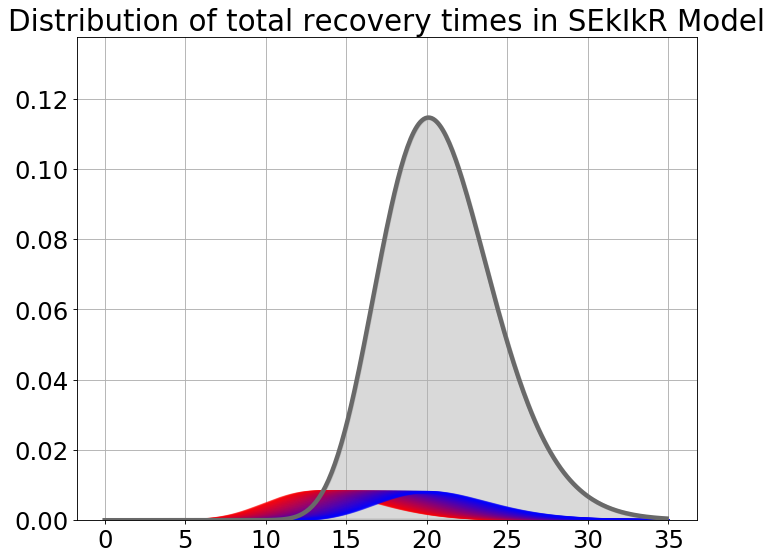

In [6]:
S = data['X'][:, 0];
Is1 = np.transpose(data['X'][:, (M + KE*M)::M])
Es1 = np.transpose(data['X'][:, (M):(M + KE*M):M])
t = data['t'];

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

for i in range(KE) :
    plt.plot(t, Es1[i], lw = 2, color = np.array([1 - i/KE,0,i/KE]), alpha = 0.5)

plt.plot(t[0:-1], np.diff(1 - (np.sum(Es1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey')
plt.fill_between(t[0:-1], np.diff(1 - (np.sum(Es1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey', alpha = 0.25)
plt.grid();
plt.ylim(0, 1.2 * np.max(np.diff(1 - (np.sum(Es1,0))/np.diff(t)[0] ) ))
plt.title("Distribution of incubation times in SEkIkR Model");

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')



for i in range(K) :
    plt.plot(t, Is1[i], lw = 2, color = np.array([1 - i/K,0,i/K]), alpha = 0.5)
    

plt.plot(t[0:-1], np.diff(1 - (np.sum(Is1,0) + np.sum(Es1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey')
plt.fill_between(t[0:-1], np.diff(1 - (np.sum(Is1,0)+np.sum(Es1,0))/np.diff(t)[0]), lw = 4, color = 'dimgrey', alpha = 0.25)
plt.grid()
plt.ylim(0, 1.2 * np.max(np.diff(1 - (np.sum(Es1,0) + np.sum(Is1,0))/np.diff(t)[0] ) ))
plt.title("Distribution of total recovery times in SEkIkR Model");